In [1]:
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm_notebook as tqdm

from kflib import *

plt.rcParams["figure.figsize"] = (20, 6)

In [2]:
N = 40
F = 8
x0 = F * np.ones(N)  # Initial state (equilibrium)
x0[0] += 0.01  # Add small perturbation to the first variable
x = l96_step(x0, 10)
x_one = l96_step(x0, 73.0)  # spin up
x = l96_step(x_one[-1], 73.0)
x_last = x_one[-1]

if not (os.path.exists("datawithnoise.txt") and os.path.exists("gendata.txt")):
    data = x[::5]
    np.savetxt("gendata.txt", data)
    random_ls = np.random.randn(data.shape[0], x[::5].shape[1])
    datawithnoise = data + random_ls
    np.savetxt("datawithnoise.txt", datawithnoise)
else:
    data = np.loadtxt("gendata.txt")
    datawithnoise = np.loadtxt("datawithnoise.txt")

### とりあえずB固定で同化を回す

In [3]:
xferror_before_assim, xferror_after_assim, trpa,xa_ls= henbun_with_xa(x_last, data, datawithnoise,step=1460)

In [4]:
np.array(xa_ls).shape

(1460, 40)

In [5]:
score = np.array(xferror_after_assim)[100:].mean()
print(score)

0.5770500434074928


In [15]:
def findepsb():
    # eps^b
    baseB = np.zeros([N,N])
    for i in range(data.shape[0]-4):
        basexa = xa_ls[i]
        nextxa = xa_ls[i+4]
        eb = l96_step(basexa, 0.4)[-1] - l96_step(nextxa, 0.2)[-1]
        eb = eb.reshape([eb.shape[0],1])
        baseB = baseB + eb @ eb.T
    return baseB / (data.shape[0]-4)

In [19]:
def findB():
    min_score = 10
    min_idx = 0.0
    idx_ls=[]
    score_ls=[]
    baseB = findepsb()
    for alpha in np.arange(0.01, 1.0,0.01):
        xferror_before_assim, xferror_after_assim, trpa = henbun(x_last, data, datawithnoise,step=1460,B=alpha*baseB)
        score = np.array(xferror_after_assim)[100:].mean()
        idx_ls.append(alpha)
        score_ls.append(score)
        if score < min_score:
            score =min_score
            min_idx = alpha
    return idx_ls, score_ls,min_idx * baseB

In [20]:
idx_ls, score_ls,bestB =findB()

[&lt;matplotlib.lines.Line2D at 0x7f11dffc9f70&gt;]

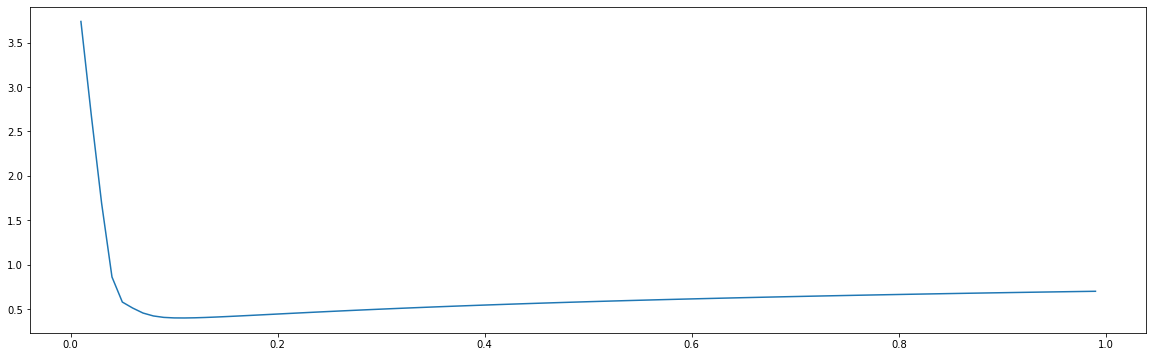

In [21]:
plt.plot(idx_ls, score_ls)

In [22]:
score_ls

[3.7375891849073133,
 2.6838968625646156,
 1.6891115769953888,
 0.8603435492260904,
 0.5782533744292925,
 0.510736509898129,
 0.45453246471529996,
 0.4218348349367351,
 0.40565092721188944,
 0.39979260241824044,
 0.3990742729943004,
 0.4010931331997667,
 0.4047232992274388,
 0.40932974233915037,
 0.41452890061339204,
 0.42008346191513396,
 0.4258432112759151,
 0.43171051309905023,
 0.43762020942051516,
 0.44352781566672095,
 0.4494024348987264,
 0.45522237544096233,
 0.46097235109630846,
 0.46664163493916183,
 0.4722228060127861,
 0.47771087631642584,
 0.4831026689413273,
 0.4883963665422016,
 0.49359117811505654,
 0.498687089689209,
 0.5036846756460723,
 0.5085849545503827,
 0.5133892781239416,
 0.5180992451988976,
 0.5227166346986399,
 0.5272433532464469,
 0.5316813941093996,
 0.536032804986855,
 0.5402996627410598,
 0.5444840536043262,
 0.5485880577250789,
 0.5526137371636178,
 0.5565631266384733,
 0.5604382264706959,
 0.564240997287117,
 0.5679733561324548,
 0.5716371737099466,
 0.

In [23]:
xferror_before_assim, xferror_after_assim, trpa = henbun(x_last, data, datawithnoise,step=1460,B=np.eye(N))

In [24]:
print(np.array(xferror_after_assim)[:101].mean())

0.6047026572275996


[&lt;matplotlib.lines.Line2D at 0x7f11dc4c34f0&gt;]

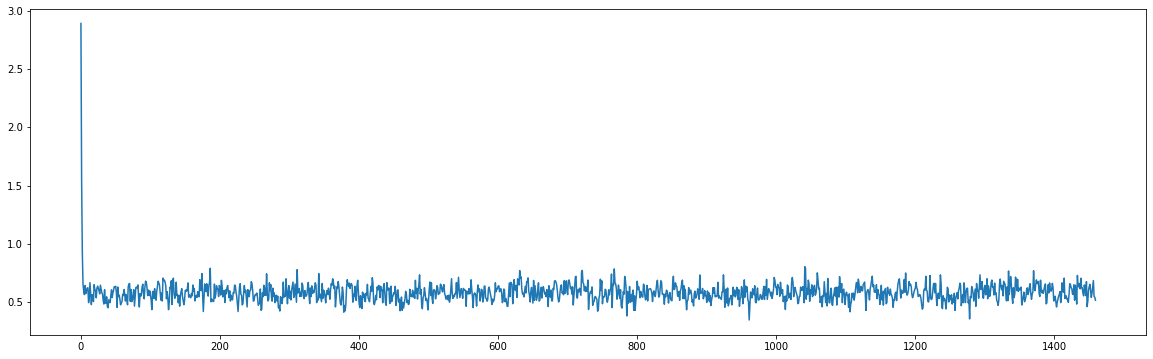

In [25]:
plt.plot(xferror_after_assim)